In [10]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import folium
import math

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = 'Challenge1'

In [11]:
# Region of Interest
region_name = 'ROI'
min_lon, min_lat = (144.35052, -38.12691)  # Lower-left corner
max_lon, max_lat = (153.614, -16.048582)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)
latitude = (min_lat, max_lat)
longitude = (min_lon, max_lon)

In [12]:
def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360/degree)/math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

def display_map(latitude = None, longitude = None):
    
    margin = -0.5
    zoom_bias = 0
    lat_zoom_level = _degree_to_zoom_level(margin = margin, *latitude ) + zoom_bias
    lon_zoom_level = _degree_to_zoom_level(margin = margin, *longitude) + zoom_bias
    zoom_level = min(lat_zoom_level, lon_zoom_level) 
    center = [np.mean(latitude), np.mean(longitude)]
    
    map_hybrid = folium.Map(location=center,zoom_start=zoom_level, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",attr="Google")
    
    line_segments = [(latitude[0],longitude[0]),(latitude[0],longitude[1]),
                     (latitude[1],longitude[1]),(latitude[1],longitude[0]),
                     (latitude[0],longitude[0])]
    
    map_hybrid.add_child(folium.features.PolyLine(locations=line_segments,color='red',opacity=0.8))
    map_hybrid.add_child(folium.features.LatLngPopup())        

    return map_hybrid

In [13]:
# Plot bounding box on a map
f = folium.Figure(width=600, height=600)
m = display_map(latitude,longitude)
f.add_child(m)

In [14]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [15]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['aet','def','pdsi','pet','ppt','q','soil','srad','swe','tmax','tmin','vap','vpd','ws']


# Features to take, in form '<asset>_<metric>'
features=['aet_mean','def_mean','pdsi_mean','pet_mean','ppt_mean','q_mean','soil_mean','srad_mean','swe_mean','tmax_mean','tmin_mean'
          ,'vap_mean','vpd_mean','ws_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 1024)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['aet_mean', 'def_mean', 'pdsi_mean', 'pet_mean', 'ppt_mean',
       'q_mean', 'soil_mean', 'srad_mean', 'swe_mean', 'tmax_mean',
       'tmin_mean', 'vap_mean', 'vpd_mean', 'ws_mean'], dtype='<U9')

In [16]:
target_data = pd.read_csv('species only target_data.csv')

In [17]:
target_data = pd.DataFrame(target_data)


In [18]:
target_data = target_data.reset_index(drop=True).assign(key=lambda x: x.index)

In [19]:
target_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key
0,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1,0
1,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1,1
2,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1,2
3,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1,3
4,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1,4
...,...,...,...,...,...,...,...,...,...,...
49298,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax,1,49298
49299,2981077059,2018-11-22 03:59:00,Australia,Australia,New South Wales,-34.791600,150.779300,Litoria Fallax,1,49299
49300,2573827842,2019-04-22 18:11:00,Australia,Australia,Queensland,-27.497691,153.018211,Litoria Fallax,1,49300
49301,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera,0,49301


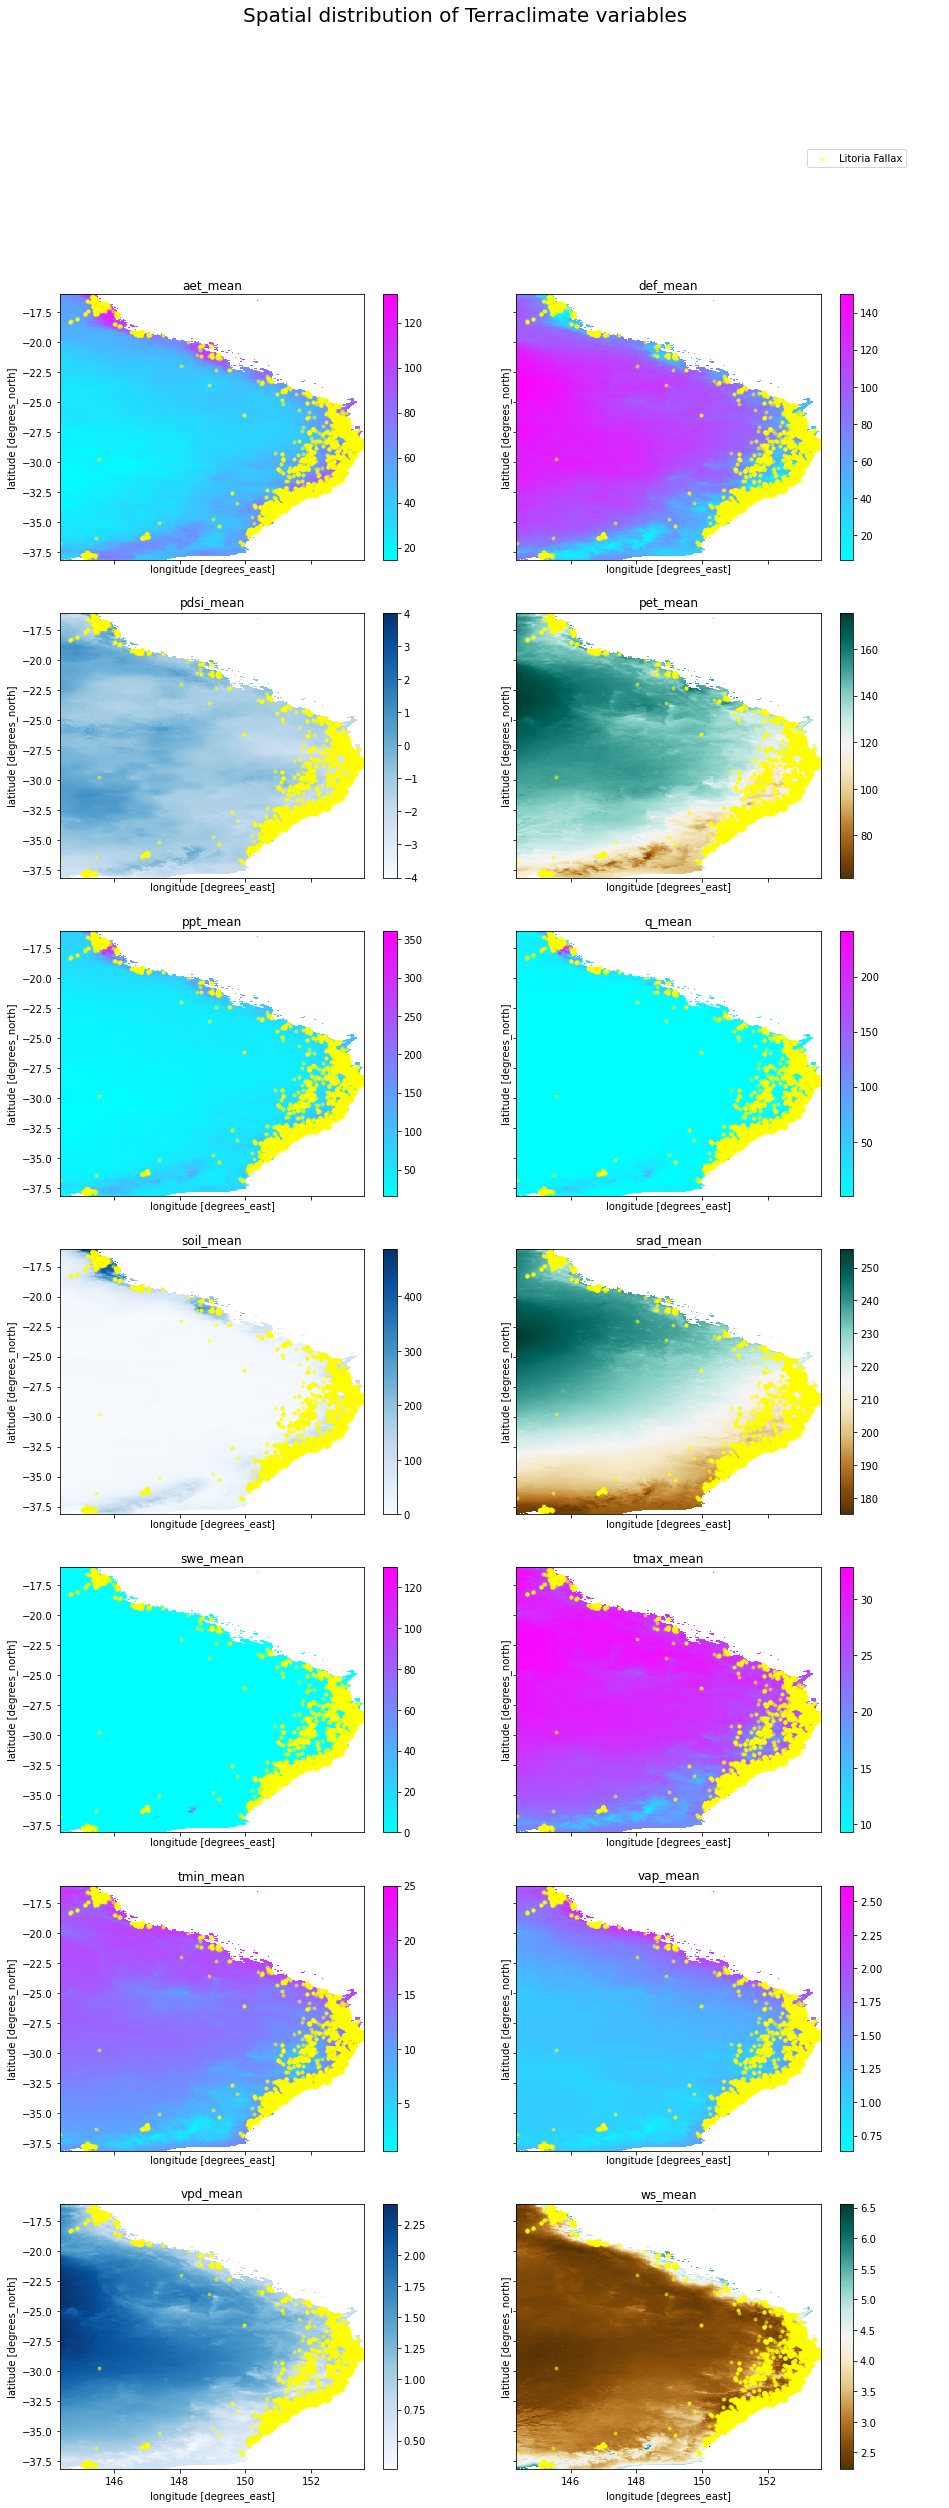

In [20]:
nrow = 7
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(15, 40), sharex=True, sharey=True)

bands = weather_data.band.values
filt = target_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG","cool", "cool", "Blues", "BrBG","cool", "cool","cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(target_data[filt].decimalLongitude, target_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label='Litoria Fallax' if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

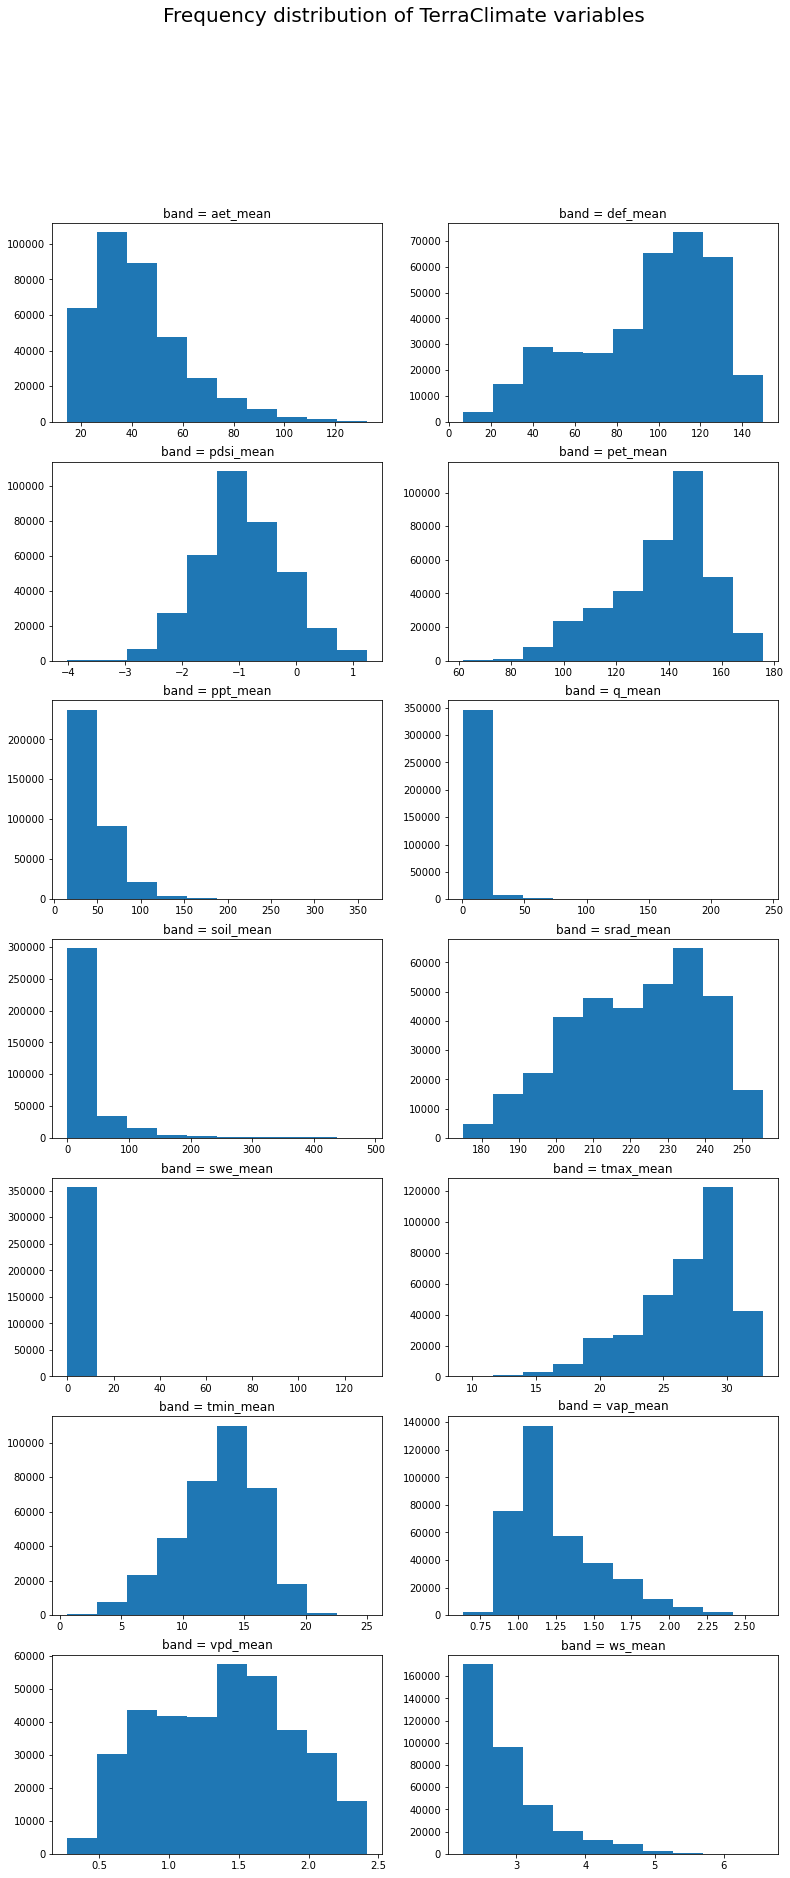

In [21]:
nrow = 7
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 30))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

In [22]:
print(weather_data)

<xarray.DataArray (band: 14, y: 1024, x: 512)>
array([[[36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        [36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        [36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        ...,
        [65.45      , 65.45      , 65.25      , ...,         nan,
                 nan,         nan],
        [65.36666667, 65.36666667, 65.71666667, ...,         nan,
                 nan,         nan],
        [65.36666667, 65.36666667, 65.71666667, ...,         nan,
                 nan,         nan]],

       [[76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
        [76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
        [76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
...
        [ 1.5619

In [23]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(target_data.decimalLongitude, dims="key", coords={"key": target_data.key}), 
                y=xr.DataArray(target_data.decimalLatitude, dims="key", coords={"key": target_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(target_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,ppt_mean,q_mean,soil_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1,0,...,97.766667,14.366667,75.566667,196.116667,0.0,23.578335,13.778335,1.451000,0.716833,4.141667
1,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1,1,...,89.583333,9.933333,80.833333,191.533333,0.0,23.538335,14.068335,1.435667,0.755167,4.315000
2,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1,2,...,91.600000,10.333333,95.583333,201.816667,0.0,23.356668,10.981668,1.253167,0.769500,2.875000
3,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1,3,...,84.133333,8.866667,73.650000,199.816667,0.0,23.895002,13.938335,1.473000,0.737833,4.123333
4,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1,4,...,81.216667,8.550000,61.833333,198.766667,0.0,23.756668,13.061669,1.433333,0.724333,3.653333


In [24]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49303 entries, 0 to 49302
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gbifID            49303 non-null  int64  
 1   eventDate         49303 non-null  object 
 2   country           49303 non-null  object 
 3   continent         49303 non-null  object 
 4   stateProvince     49302 non-null  object 
 5   decimalLatitude   49303 non-null  float64
 6   decimalLongitude  49303 non-null  float64
 7   species           49303 non-null  object 
 8   occurrenceStatus  49303 non-null  int64  
 9   key               49303 non-null  int64  
 10  aet_mean          49258 non-null  float64
 11  def_mean          49258 non-null  float64
 12  pdsi_mean         49258 non-null  float64
 13  pet_mean          49258 non-null  float64
 14  ppt_mean          49258 non-null  float64
 15  q_mean            49258 non-null  float64
 16  soil_mean         49258 non-null  float6

In [25]:
merge = model_data

In [26]:
merge.to_csv('model_data.csv')